# Multi-City Green Space Detection
## Training Random Forest with WorldCover 2021 as Ground Truth

**Training Cities:** 9 cities for robust model training

**Key Features:**
- Uses **WorldCover 2021** as ground truth for training
- Green classes: Tree cover (10), Shrubland (20), Grassland (30), Mangroves (95)
- Multi-temporal Sentinel-2 data (April, August, November)
- 21 bands: 4 spectral bands × 3 months + 3 vegetation indices × 3 months
- **Cross-city training** for better generalization

## 1. Import Libraries

In [18]:
import json
import os
import glob
import numpy as np
import rasterio
from rasterio.warp import reproject, Resampling
from pathlib import Path
import geopandas as gpd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


## 2. Configuration

In [ ]:
# Base paths - using relative paths from project root
# Run notebooks from the project root directory: python -m jupyter notebook
import os

# Find project root (go up from notebooks/training/)
NOTEBOOK_DIR = os.path.dirname(os.path.abspath("__file__"))
PROJECT_ROOT = os.path.abspath(os.path.join(NOTEBOOK_DIR, "..", ".."))

# If running from project root directly
if os.path.exists("data") and os.path.exists("models"):
    PROJECT_ROOT = os.getcwd()
# If running from notebooks/training/
elif os.path.exists("../../data") and os.path.exists("../../models"):
    PROJECT_ROOT = os.path.abspath("../..")
# Fallback
else:
    PROJECT_ROOT = os.getcwd()
    print(f"Warning: Could not detect project root. Using: {PROJECT_ROOT}")

# Derived paths
DATA_PATH = os.path.join(PROJECT_ROOT, "data")
MODELS_PATH = os.path.join(PROJECT_ROOT, "models")
GEOJSON_FOLDER = os.path.join(DATA_PATH, "aois")

# Output folder
OUTPUT_FOLDER = os.path.join(PROJECT_ROOT, "outputs", "multi_city_training")
os.makedirs(OUTPUT_FOLDER, exist_ok=True)
os.makedirs(MODELS_PATH, exist_ok=True)

# Create timestamped run folder
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
RUN_FOLDER = os.path.join(OUTPUT_FOLDER, f"run_{timestamp}")
os.makedirs(RUN_FOLDER, exist_ok=True)

# WorldCover green classes
GREEN_CLASSES = [10, 20, 30, 95]  # Tree, Shrub, Grass, Mangroves

# Define cities with their specific file locations
# All data now in unified data/ folder structure
CITY_FILES = {
    "Amsterdam": {
        "stack": os.path.join(DATA_PATH, "sentinel_stacks", "Amsterdam_MultiMonth_stack.tif"),
        "worldcover": os.path.join(DATA_PATH, "worldcover", "Amsterdam_WorldCover_2021.tif"),
        "geojson": os.path.join(GEOJSON_FOLDER, "Amsterdam.geojson"),
    },
    "Auckland": {
        "stack": os.path.join(DATA_PATH, "sentinel_stacks", "Auckland_MultiMonth_stack.tif"),
        "worldcover": os.path.join(DATA_PATH, "worldcover", "Auckland_WorldCover_2021.tif"),
        "geojson": os.path.join(GEOJSON_FOLDER, "Auckland.geojson"),
    },
    "Barcelona": {
        "stack": os.path.join(DATA_PATH, "sentinel_stacks", "Barcelona_MultiMonth_stack.tif"),
        "worldcover": os.path.join(DATA_PATH, "worldcover", "Barcelona_WorldCover_2021.tif"),
        "geojson": os.path.join(GEOJSON_FOLDER, "Barcelona.geojson"),
    },
    "Sydney": {
        "stack": os.path.join(DATA_PATH, "sentinel_stacks", "Sydney_MultiMonth_stack.tif"),
        "worldcover": os.path.join(DATA_PATH, "worldcover", "Sydney_WorldCover_2021.tif"),
        "geojson": os.path.join(GEOJSON_FOLDER, "Sydney.geojson"),
    },
    "Toronto": {
        "stack": os.path.join(DATA_PATH, "sentinel_stacks", "Toronto_MultiMonth_stack.tif"),
        "worldcover": os.path.join(DATA_PATH, "worldcover", "Toronto_WorldCover_2021.tif"),
        "geojson": os.path.join(GEOJSON_FOLDER, "Toronto.geojson"),
    },
    "Vienna": {
        "stack": os.path.join(DATA_PATH, "sentinel_stacks", "Wien_MultiMonth_stack.tif"),
        "worldcover": os.path.join(DATA_PATH, "worldcover", "Vienna_WorldCover_2021.tif"),
        "geojson": os.path.join(GEOJSON_FOLDER, "Vienna.geojson"),
    },
    "London": {
        "stack": os.path.join(DATA_PATH, "sentinel_stacks", "London_MultiMonth_stack.tif"),
        "worldcover": os.path.join(DATA_PATH, "worldcover", "London_WorldCover_2021.tif"),
        "geojson": os.path.join(GEOJSON_FOLDER, "London.geojson"),
    },
    "Melbourne": {
        "stack": os.path.join(DATA_PATH, "sentinel_stacks", "Melbourne_MultiMonth_stack.tif"),
        "worldcover": os.path.join(DATA_PATH, "worldcover", "Melbourne_WorldCover_2021.tif"),
        "geojson": os.path.join(GEOJSON_FOLDER, "Melbourne.geojson"),
    },
    "Paris": {
        "stack": os.path.join(DATA_PATH, "sentinel_stacks", "Paris_MultiMonth_stack.tif"),
        "worldcover": os.path.join(DATA_PATH, "worldcover", "Paris_WorldCover_2021.tif"),
        "geojson": os.path.join(GEOJSON_FOLDER, "Paris.geojson"),
    },
    "San_Francisco": {
        "stack": os.path.join(DATA_PATH, "sentinel_stacks", "San_Francisco_MultiMonth_stack.tif"),
        "worldcover": os.path.join(DATA_PATH, "worldcover", "San_Francisco_WorldCover_2021.tif"),
        "geojson": os.path.join(GEOJSON_FOLDER, "San_Francisco.geojson"),
    },
    "Seattle": {
        "stack": os.path.join(DATA_PATH, "sentinel_stacks", "Seattle_MultiMonth_stack.tif"),
        "worldcover": os.path.join(DATA_PATH, "worldcover", "Seattle_WorldCover_2021.tif"),
        "geojson": os.path.join(GEOJSON_FOLDER, "Seattle.geojson"),
    },
}

print("Configuration loaded")
print(f"  Project root: {PROJECT_ROOT}")
print(f"  Data path: {DATA_PATH}")
print(f"  Models path: {MODELS_PATH}")
print(f"  Output folder: {RUN_FOLDER}")
print(f"  Target cities: {len(CITY_FILES)}")
for city in CITY_FILES:
    print(f"    - {city}")

## 3. Discover Available Cities
### Find all cities with Multi-Month stacks

In [20]:
print("="*70)
print("DISCOVERING AVAILABLE CITIES")
print("="*70)

print(f"\nChecking {len(CITY_FILES)} configured cities...")

cities_data = []
missing_cities = []

for city_name, paths in CITY_FILES.items():
    stack_file = paths["stack"]
    worldcover_file = paths["worldcover"]
    geojson_file = paths["geojson"]
    
    # Check status
    has_stack = os.path.exists(stack_file)
    has_worldcover = os.path.exists(worldcover_file)
    has_geojson = os.path.exists(geojson_file)
    
    status_stack = "✓" if has_stack else "✗"
    status_geojson = "✓" if has_geojson else "✗"
    status_worldcover = "✓" if has_worldcover else "✗"
    
    print(f"  {city_name:15s} - Stack: {status_stack}  GeoJSON: {status_geojson}  WorldCover: {status_worldcover}")
    
    if has_stack and has_geojson and has_worldcover:
        cities_data.append({
            "name": city_name,
            "stack_file": stack_file,
            "geojson_file": geojson_file,
            "worldcover_file": worldcover_file
        })
    else:
        missing = []
        if not has_stack: missing.append("Stack")
        if not has_geojson: missing.append("GeoJSON")
        if not has_worldcover: missing.append("WorldCover")
        missing_cities.append(f"{city_name} (missing: {', '.join(missing)})")

# Filter cities with all required data
complete_cities = cities_data

print(f"\n{'='*70}")
print(f"Cities with complete data: {len(complete_cities)}/{len(CITY_FILES)}")
print(f"{'='*70}")

if missing_cities:
    print(f"\n⚠ Skipped cities:")
    for city in missing_cities:
        print(f"  - {city}")

if len(complete_cities) == 0:
    raise ValueError("No cities with complete data found! Check your file paths.")

print(f"\n✓ Ready to train with {len(complete_cities)} cities:")
for city in complete_cities:
    print(f"  ✓ {city['name']}")

DISCOVERING AVAILABLE CITIES

Checking 11 configured cities...
  Amsterdam       - Stack: ✓  GeoJSON: ✓  WorldCover: ✓
  Auckland        - Stack: ✓  GeoJSON: ✓  WorldCover: ✓
  Barcelona       - Stack: ✓  GeoJSON: ✓  WorldCover: ✓
  Sydney          - Stack: ✓  GeoJSON: ✓  WorldCover: ✓
  Toronto         - Stack: ✓  GeoJSON: ✓  WorldCover: ✓
  Vienna          - Stack: ✓  GeoJSON: ✓  WorldCover: ✓
  London          - Stack: ✓  GeoJSON: ✓  WorldCover: ✓
  Melbourne       - Stack: ✓  GeoJSON: ✓  WorldCover: ✓
  Paris           - Stack: ✓  GeoJSON: ✓  WorldCover: ✓
  San_Francisco   - Stack: ✓  GeoJSON: ✓  WorldCover: ✓
  Seattle         - Stack: ✓  GeoJSON: ✓  WorldCover: ✓

Cities with complete data: 11/11

✓ Ready to train with 11 cities:
  ✓ Amsterdam
  ✓ Auckland
  ✓ Barcelona
  ✓ Sydney
  ✓ Toronto
  ✓ Vienna
  ✓ London
  ✓ Melbourne
  ✓ Paris
  ✓ San_Francisco
  ✓ Seattle


## 4. Load and Process All Cities
### Load Sentinel-2 stacks and create WorldCover labels for each city

In [21]:
print("\n" + "="*70)
print("LOADING AND PROCESSING ALL CITIES")
print("="*70)

# Expected number of bands (set to None to auto-detect from first city)
EXPECTED_BANDS = None

# Maximum samples per class per city (for balanced sampling)
# This prevents memory issues and ensures balanced training
MAX_SAMPLES_PER_CLASS_PER_CITY = 100000

all_X = []  # Features from all cities
all_y = []  # Labels from all cities
city_info = []  # Track which city each sample came from
skipped_cities = []  # Track skipped cities

for city_data in tqdm(complete_cities, desc="Processing cities"):
    city_name = city_data["name"]
    stack_file = city_data["stack_file"]
    worldcover_file = city_data["worldcover_file"]
    
    print(f"\n{'='*70}")
    print(f"Processing: {city_name}")
    print(f"{'='*70}")
    
    try:
        # Load Sentinel-2 stack
        with rasterio.open(stack_file) as src:
            X_stack = src.read()  # Shape: (n_bands, height, width)
            stack_transform = src.transform
            stack_shape = (src.height, src.width)
            stack_crs = src.crs
        
        n_bands = X_stack.shape[0]
        print(f"  ✓ Loaded Sentinel-2 stack: {X_stack.shape} ({n_bands} bands)")
        
        # Set expected bands from first city, or check consistency
        if EXPECTED_BANDS is None:
            EXPECTED_BANDS = n_bands
            print(f"  ℹ Setting expected bands to {EXPECTED_BANDS}")
        elif n_bands != EXPECTED_BANDS:
            print(f"  ⚠ SKIPPING: Expected {EXPECTED_BANDS} bands, but found {n_bands} bands")
            skipped_cities.append({"name": city_name, "reason": f"Band mismatch: {n_bands} vs {EXPECTED_BANDS}"})
            continue
        
        # Load and reproject WorldCover to match Sentinel-2
        with rasterio.open(worldcover_file) as src:
            worldcover_data = np.empty(stack_shape, dtype=np.uint8)
            
            reproject(
                source=rasterio.band(src, 1),
                destination=worldcover_data,
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=stack_transform,
                dst_crs=stack_crs,
                resampling=Resampling.nearest
            )
        
        # Convert to binary green/non-green labels
        labels = np.isin(worldcover_data, GREEN_CLASSES).astype(np.uint8)
        
        green_percentage = 100 * labels.sum() / labels.size
        print(f"  ✓ WorldCover labels: {labels.shape} ({green_percentage:.2f}% green)")
        
        # Reshape for sklearn: (n_samples, n_features)
        n_pixels = X_stack.shape[1] * X_stack.shape[2]
        
        X = X_stack.reshape(n_bands, -1).T  # Shape: (n_pixels, n_bands)
        y = labels.flatten()  # Shape: (n_pixels,)
        
        # Remove NaN values
        valid_mask = ~np.isnan(X).any(axis=1)
        X_clean = X[valid_mask]
        y_clean = y[valid_mask]
        
        print(f"  ✓ Valid samples: {len(X_clean):,} ({100*len(X_clean)/n_pixels:.1f}% of pixels)")
        
        # BALANCED SAMPLING: Take equal samples from each class
        green_indices = np.where(y_clean == 1)[0]
        nongreen_indices = np.where(y_clean == 0)[0]
        
        n_green = len(green_indices)
        n_nongreen = len(nongreen_indices)
        
        # Sample equal amounts from each class (up to MAX_SAMPLES_PER_CLASS_PER_CITY)
        n_samples_per_class = min(n_green, n_nongreen, MAX_SAMPLES_PER_CLASS_PER_CITY)
        
        # Random sampling
        np.random.seed(42)  # For reproducibility
        sampled_green = np.random.choice(green_indices, n_samples_per_class, replace=False)
        sampled_nongreen = np.random.choice(nongreen_indices, n_samples_per_class, replace=False)
        
        sampled_indices = np.concatenate([sampled_green, sampled_nongreen])
        np.random.shuffle(sampled_indices)
        
        X_sampled = X_clean[sampled_indices]
        y_sampled = y_clean[sampled_indices]
        
        print(f"  ✓ Balanced sampling: {len(X_sampled):,} samples ({n_samples_per_class:,} per class)")
        print(f"    - Green: {np.sum(y_sampled == 1):,} ({100*np.sum(y_sampled == 1)/len(y_sampled):.1f}%)")
        print(f"    - Non-green: {np.sum(y_sampled == 0):,} ({100*np.sum(y_sampled == 0)/len(y_sampled):.1f}%)")
        
        # Add to combined dataset
        all_X.append(X_sampled)
        all_y.append(y_sampled)
        city_info.extend([city_name] * len(X_sampled))
        
    except Exception as e:
        print(f"  ✗ Error processing {city_name}: {e}")
        skipped_cities.append({"name": city_name, "reason": str(e)})
        continue

print(f"\n{'='*70}")
print("DATA AGGREGATION")
print(f"{'='*70}")

# Report skipped cities
if skipped_cities:
    print(f"\n⚠ Skipped {len(skipped_cities)} cities due to issues:")
    for city in skipped_cities:
        print(f"  - {city['name']}: {city['reason']}")

# Check if we have any data
if len(all_X) == 0:
    raise ValueError("No valid city data loaded! Check that all stacks have the same number of bands.")

# Combine all data
X_combined = np.vstack(all_X)
y_combined = np.hstack(all_y)
city_info = np.array(city_info)

print(f"\nCombined dataset (BALANCED):")
print(f"  Cities included: {len(all_X)}")
print(f"  Total samples: {len(X_combined):,}")
print(f"  Features (bands): {X_combined.shape[1]}")
print(f"  Green samples: {np.sum(y_combined == 1):,} ({100*np.sum(y_combined == 1)/len(y_combined):.1f}%)")
print(f"  Non-green samples: {np.sum(y_combined == 0):,} ({100*np.sum(y_combined == 0)/len(y_combined):.1f}%)")

# Save city distribution
print(f"\nSamples per city:")
unique_cities = np.unique(city_info)
for city_name in unique_cities:
    city_samples = np.sum(city_info == city_name)
    print(f"  {city_name:20s}: {city_samples:>10,} samples")

print(f"{'='*70}")


LOADING AND PROCESSING ALL CITIES


Processing cities:  27%|██▋       | 3/11 [00:00<00:00, 21.16it/s]


Processing: Amsterdam
  ✓ Loaded Sentinel-2 stack: (21, 512, 512) (21 bands)
  ℹ Setting expected bands to 21
  ✓ WorldCover labels: (512, 512) (20.54% green)
  ✓ Valid samples: 262,000 (99.9% of pixels)
  ✓ Balanced sampling: 107,694 samples (53,847 per class)
    - Green: 53,847 (50.0%)
    - Non-green: 53,847 (50.0%)

Processing: Auckland
  ✓ Loaded Sentinel-2 stack: (21, 512, 512) (21 bands)
  ✓ WorldCover labels: (512, 512) (19.74% green)
  ✓ Valid samples: 262,046 (100.0% of pixels)
  ✓ Balanced sampling: 103,460 samples (51,730 per class)
    - Green: 51,730 (50.0%)
    - Non-green: 51,730 (50.0%)

Processing: Barcelona
  ✓ Loaded Sentinel-2 stack: (21, 512, 512) (21 bands)
  ✓ WorldCover labels: (512, 512) (12.72% green)
  ✓ Valid samples: 262,114 (100.0% of pixels)
  ✓ Balanced sampling: 66,708 samples (33,354 per class)
    - Green: 33,354 (50.0%)
    - Non-green: 33,354 (50.0%)

Processing: Sydney
  ✓ Loaded Sentinel-2 stack: (21, 512, 512) (21 bands)
  ✓ WorldCover labels:

Processing cities:  55%|█████▍    | 6/11 [00:00<00:00, 21.36it/s]

  ✓ Loaded Sentinel-2 stack: (21, 512, 512) (21 bands)
  ✓ WorldCover labels: (512, 512) (18.82% green)
  ✓ Valid samples: 262,069 (100.0% of pixels)
  ✓ Balanced sampling: 98,638 samples (49,319 per class)
    - Green: 49,319 (50.0%)
    - Non-green: 49,319 (50.0%)

Processing: Vienna
  ✓ Loaded Sentinel-2 stack: (21, 512, 512) (21 bands)
  ✓ WorldCover labels: (512, 512) (15.66% green)
  ✓ Valid samples: 262,034 (100.0% of pixels)
  ✓ Balanced sampling: 82,098 samples (41,049 per class)
    - Green: 41,049 (50.0%)
    - Non-green: 41,049 (50.0%)

Processing: London
  ✓ Loaded Sentinel-2 stack: (21, 512, 512) (21 bands)
  ✓ WorldCover labels: (512, 512) (20.99% green)
  ✓ Valid samples: 261,947 (99.9% of pixels)
  ✓ Balanced sampling: 110,022 samples (55,011 per class)
    - Green: 55,011 (50.0%)
    - Non-green: 55,011 (50.0%)

Processing: Melbourne
  ✓ Loaded Sentinel-2 stack: (21, 512, 512) (21 bands)
  ✓ WorldCover labels: (512, 512) (22.04% green)
  ✓ Valid samples: 262,017 (100.

Processing cities: 100%|██████████| 11/11 [00:00<00:00, 21.82it/s]


Processing: San_Francisco
  ✓ Loaded Sentinel-2 stack: (21, 512, 512) (21 bands)
  ✓ WorldCover labels: (512, 512) (8.94% green)
  ✓ Valid samples: 261,979 (99.9% of pixels)
  ✓ Balanced sampling: 46,882 samples (23,441 per class)
    - Green: 23,441 (50.0%)
    - Non-green: 23,441 (50.0%)

Processing: Seattle
  ✓ Loaded Sentinel-2 stack: (21, 512, 512) (21 bands)
  ✓ WorldCover labels: (512, 512) (16.45% green)
  ✓ Valid samples: 262,045 (100.0% of pixels)
  ✓ Balanced sampling: 86,238 samples (43,119 per class)
    - Green: 43,119 (50.0%)
    - Non-green: 43,119 (50.0%)

DATA AGGREGATION

Combined dataset (BALANCED):


  Cities included: 11
  Total samples: 965,150
  Features (bands): 21
  Green samples: 482,575 (50.0%)
  Non-green samples: 482,575 (50.0%)

Samples per city:
  Amsterdam           :    107,694 samples
  Auckland            :    103,460 samples
  Barcelona           :     66,708 samples
  London              :    110,022 samples
  Melbourne           :    115,540 samples
  Paris               :     46,766 samples
  San_Francisco       :     46,882 samples
  Seattle             :     86,238 samples
  Sydney              :    101,104 samples
  Toronto             :     98,638 samples
  Vienna              :     82,098 samples


## 5. Train-Test Split
### Split data for training and validation

In [22]:
print("\n" + "="*70)
print("TRAIN-TEST SPLIT & FEATURE NORMALIZATION")
print("="*70)

# Split data (80-20)
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y_combined, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_combined
)

print(f"\nDataset split:")
print(f"  Training samples: {len(X_train):,}")
print(f"    - Green: {np.sum(y_train == 1):,} ({100*np.sum(y_train == 1)/len(y_train):.1f}%)")
print(f"    - Non-green: {np.sum(y_train == 0):,} ({100*np.sum(y_train == 0)/len(y_train):.1f}%)")
print(f"\n  Testing samples: {len(X_test):,}")
print(f"    - Green: {np.sum(y_test == 1):,} ({100*np.sum(y_test == 1)/len(y_test):.1f}%)")
print(f"    - Non-green: {np.sum(y_test == 0):,} ({100*np.sum(y_test == 0)/len(y_test):.1f}%)")

# Feature normalization
print(f"\nApplying feature normalization (StandardScaler)...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"  ✓ Features normalized")
print(f"    Mean (train): {X_train_scaled.mean():.4f}")
print(f"    Std (train): {X_train_scaled.std():.4f}")

print(f"{'='*70}")


TRAIN-TEST SPLIT & FEATURE NORMALIZATION

Dataset split:
  Training samples: 772,120
    - Green: 386,060 (50.0%)
    - Non-green: 386,060 (50.0%)

  Testing samples: 193,030
    - Green: 96,515 (50.0%)
    - Non-green: 96,515 (50.0%)

Applying feature normalization (StandardScaler)...
  ✓ Features normalized
    Mean (train): 0.0000
    Std (train): 1.0000


## 6. Train Random Forest Model
### Train on multi-city dataset

In [23]:
print("\n" + "="*70)
print("TRAINING RANDOM FOREST MODEL (IMPROVED)")
print("="*70)

# Initialize Random Forest with improved parameters
rf = RandomForestClassifier(
    n_estimators=200,           # Increased from 100
    max_depth=None,             # Allow full depth (was 25)
    min_samples_split=10,       # Reduced from 50 (less restrictive)
    min_samples_leaf=5,         # Reduced from 20 (less restrictive)
    max_features='sqrt',
    class_weight=None,          # Data already balanced via sampling
    random_state=42,
    n_jobs=-1,
    verbose=1
)

print(f"\nRandom Forest parameters (IMPROVED):")
print(f"  n_estimators: {rf.n_estimators} (↑ from 100)")
print(f"  max_depth: {rf.max_depth} (was 25)")
print(f"  min_samples_split: {rf.min_samples_split} (↓ from 50)")
print(f"  min_samples_leaf: {rf.min_samples_leaf} (↓ from 20)")
print(f"  max_features: {rf.max_features}")
print(f"  class_weight: {rf.class_weight} (data already balanced via sampling)")

print(f"\nTraining Random Forest...")
print(f"  Training on {len(complete_cities)} cities")
print(f"  Training samples: {len(X_train_scaled):,}")

rf.fit(X_train_scaled, y_train)

print(f"\n✓ Model trained successfully")
print(f"{'='*70}")


TRAINING RANDOM FOREST MODEL (IMPROVED)

Random Forest parameters (IMPROVED):
  n_estimators: 200 (↑ from 100)
  max_depth: None (was 25)
  min_samples_split: 10 (↓ from 50)
  min_samples_leaf: 5 (↓ from 20)
  max_features: sqrt
  class_weight: None (data already balanced via sampling)

Training Random Forest...
  Training on 11 cities
  Training samples: 772,120


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:  1.4min



✓ Model trained successfully


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.5min finished


## 7. Evaluate Model Performance

In [24]:
print("\n" + "="*70)
print("MODEL EVALUATION")
print("="*70)

# Make predictions on scaled test data
y_pred = rf.predict(X_test_scaled)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)

print(f"\nModel Performance (trained on {len(complete_cities)} cities):")
print(f"  Accuracy:  {accuracy:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall:    {recall:.4f}  ← Key metric for green detection")
print(f"  F1-Score:  {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print(f"\nConfusion Matrix:")
print(f"                 Predicted")
print(f"               Non-Green  Green")
print(f"Actual Non-Green  {cm[0,0]:>8,}  {cm[0,1]:>8,}")
print(f"       Green      {cm[1,0]:>8,}  {cm[1,1]:>8,}")

# Calculate percentages
total_actual_green = cm[1,0] + cm[1,1]
total_actual_nongreen = cm[0,0] + cm[0,1]
green_detected = 100 * cm[1,1] / total_actual_green if total_actual_green > 0 else 0
green_missed = 100 * cm[1,0] / total_actual_green if total_actual_green > 0 else 0

print(f"\nGreen Detection Analysis:")
print(f"  Green correctly detected: {green_detected:.1f}%")
print(f"  Green missed (false negative): {green_missed:.1f}%")

# Save metrics
metrics = {
    "model": "RandomForest_Improved",
    "ground_truth": "WorldCover_2021",
    "training_cities": [city['name'] for city in complete_cities],
    "n_cities": len(complete_cities),
    "total_training_samples": int(len(X_train)),
    "total_testing_samples": int(len(X_test)),
    "accuracy": float(accuracy),
    "precision": float(precision),
    "recall": float(recall),
    "f1_score": float(f1),
    "confusion_matrix": cm.tolist(),
    "improvements": [
        "Balanced sampling (equal green/non-green per city)",
        "Feature normalization (StandardScaler)",
        "Increased n_estimators (200)",
        "Removed max_depth limit",
        "Reduced min_samples_split (10)",
        "Reduced min_samples_leaf (5)",
        "Added class_weight='balanced'"
    ]
}

with open(os.path.join(RUN_FOLDER, "metrics.json"), "w") as f:
    json.dump(metrics, f, indent=2)

print(f"\n✓ Metrics saved to: {RUN_FOLDER}/metrics.json")
print(f"{'='*70}")

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.1s



MODEL EVALUATION

Model Performance (trained on 11 cities):
  Accuracy:  0.8906
  Precision: 0.8909
  Recall:    0.8903  ← Key metric for green detection
  F1-Score:  0.8906

Confusion Matrix:
                 Predicted
               Non-Green  Green
Actual Non-Green    85,994    10,521
       Green        10,591    85,924

Green Detection Analysis:
  Green correctly detected: 89.0%
  Green missed (false negative): 11.0%

✓ Metrics saved to: /Users/tyomachka/Desktop/WU/Data_Lab.TMP/rep.infrared.city/multi_city_training/run_20260127_204907/metrics.json


[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.7s
[Parallel(n_jobs=10)]: Done 200 out of 200 | elapsed:    0.8s finished


## 8. Visualize Confusion Matrix

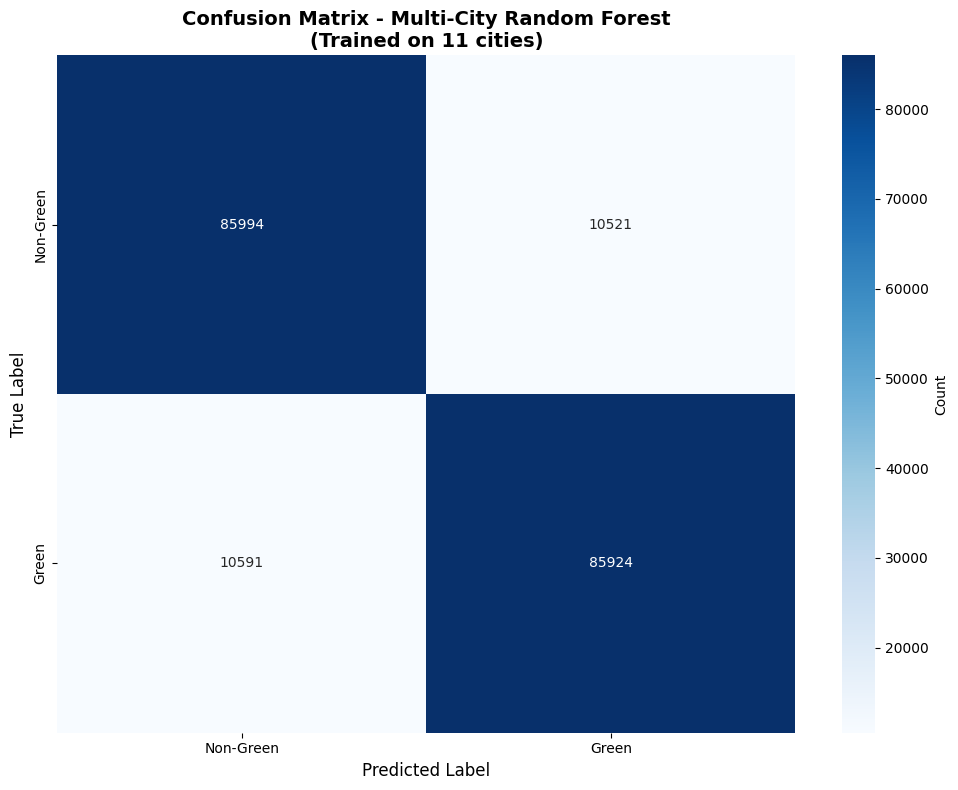

✓ Confusion matrix saved


In [25]:
# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-Green', 'Green'],
            yticklabels=['Non-Green', 'Green'],
            cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix - Multi-City Random Forest\n(Trained on {len(complete_cities)} cities)', 
          fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(RUN_FOLDER, 'confusion_matrix.png'), dpi=300, bbox_inches='tight')
plt.show()

print("✓ Confusion matrix saved")

## 9. Feature Importance Analysis

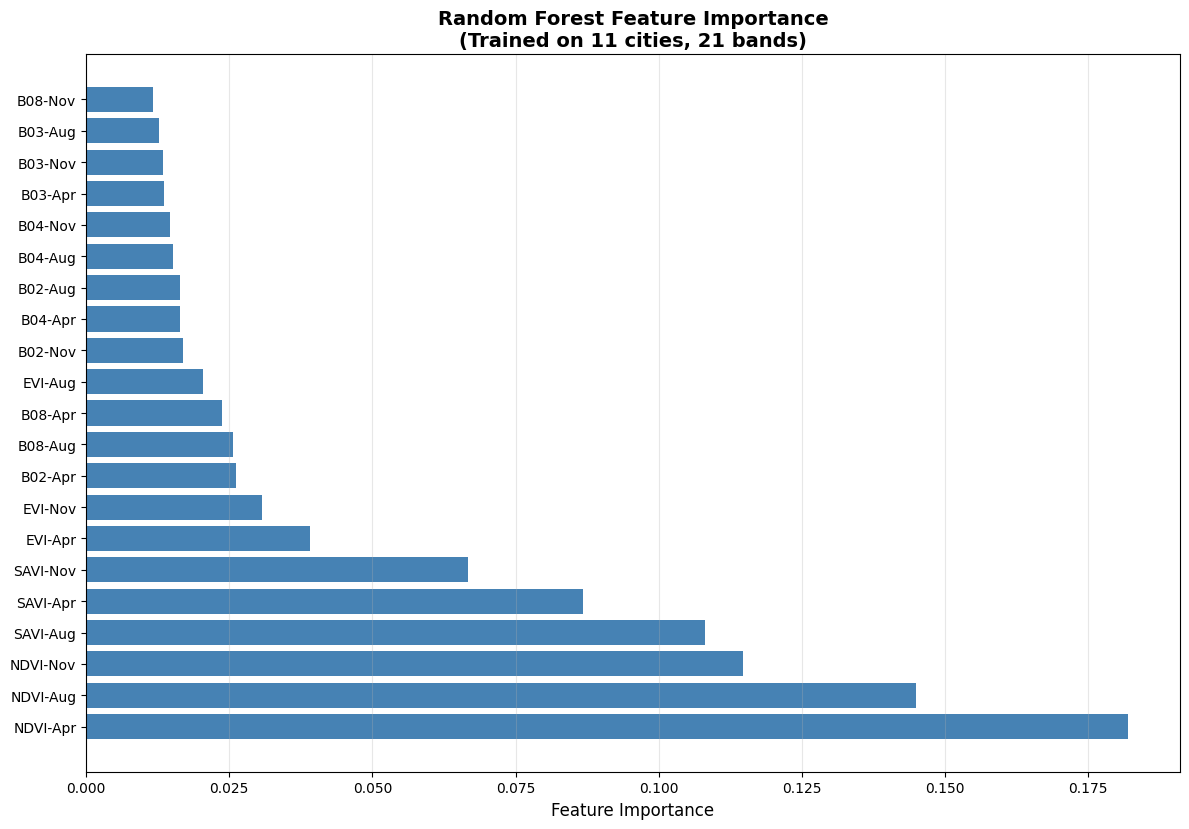

✓ Feature importance plot saved

Top 10 most important features:
   1. NDVI-Apr    : 0.1819
   2. NDVI-Aug    : 0.1449
   3. NDVI-Nov    : 0.1148
   4. SAVI-Aug    : 0.1081
   5. SAVI-Apr    : 0.0868
   6. SAVI-Nov    : 0.0667
   7. EVI-Apr     : 0.0391
   8. EVI-Nov     : 0.0308
   9. B02-Apr     : 0.0261
  10. B08-Aug     : 0.0257


In [26]:
# Get feature importances
importances = rf.feature_importances_
n_features = len(importances)

# Generate band names based on actual number of bands
if n_features == 21:
    # 21 bands: 4 spectral + 3 indices per month × 3 months
    band_names = [
        'B02-Apr', 'B03-Apr', 'B04-Apr', 'B08-Apr', 'NDVI-Apr', 'EVI-Apr', 'SAVI-Apr',
        'B02-Aug', 'B03-Aug', 'B04-Aug', 'B08-Aug', 'NDVI-Aug', 'EVI-Aug', 'SAVI-Aug',
        'B02-Nov', 'B03-Nov', 'B04-Nov', 'B08-Nov', 'NDVI-Nov', 'EVI-Nov', 'SAVI-Nov'
    ]
elif n_features == 12:
    # 12 bands: 4 spectral per month × 3 months (no indices)
    band_names = [
        'B02-Apr', 'B03-Apr', 'B04-Apr', 'B08-Apr',
        'B02-Aug', 'B03-Aug', 'B04-Aug', 'B08-Aug',
        'B02-Nov', 'B03-Nov', 'B04-Nov', 'B08-Nov'
    ]
elif n_features == 14:
    # 14 bands: possibly 4 spectral + some indices per month
    band_names = [f'Band_{i+1}' for i in range(n_features)]
    print(f"ℹ Using generic band names for {n_features} bands")
else:
    # Generic fallback
    band_names = [f'Band_{i+1}' for i in range(n_features)]
    print(f"ℹ Using generic band names for {n_features} bands")

# Sort by importance
indices = np.argsort(importances)[::-1]

# Plot feature importances
plt.figure(figsize=(12, max(8, n_features * 0.4)))
plt.barh(range(len(importances)), importances[indices], color='steelblue')
plt.yticks(range(len(importances)), [band_names[i] for i in indices])
plt.xlabel('Feature Importance', fontsize=12)
plt.title(f'Random Forest Feature Importance\n(Trained on {len(all_X)} cities, {n_features} bands)', 
          fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(RUN_FOLDER, 'feature_importance.png'), dpi=300, bbox_inches='tight')
plt.show()

print("✓ Feature importance plot saved")
print(f"\nTop 10 most important features:")
for i in range(min(10, len(importances))):
    idx = indices[i]
    print(f"  {i+1:2d}. {band_names[idx]:12s}: {importances[idx]:.4f}")

## 10. Save Trained Model

In [ ]:
import joblib
import shutil

# Save the trained model to run folder
model_file = os.path.join(RUN_FOLDER, 'random_forest_model.pkl')
joblib.dump(rf, model_file)

# Save the scaler (needed for inference!)
scaler_file = os.path.join(RUN_FOLDER, 'feature_scaler.pkl')
joblib.dump(scaler, scaler_file)

# Also save to main models folder for easy access
main_model_file = os.path.join(MODELS_PATH, 'random_forest_model.pkl')
main_scaler_file = os.path.join(MODELS_PATH, 'feature_scaler.pkl')
shutil.copy(model_file, main_model_file)
shutil.copy(scaler_file, main_scaler_file)

print(f"✓ Model saved to: {model_file}")
print(f"✓ Scaler saved to: {scaler_file}")
print(f"\n✓ Also copied to main models folder:")
print(f"  - {main_model_file}")
print(f"  - {main_scaler_file}")
print(f"\nTo load the model and scaler later:")
print(f"  import joblib")
print(f"  rf = joblib.load('models/random_forest_model.pkl')")
print(f"  scaler = joblib.load('models/feature_scaler.pkl')")
print(f"\nIMPORTANT: Always apply scaler.transform(X) before prediction!")

## 11. Per-City Performance Analysis (Optional)
### Evaluate model performance on each city individually

In [28]:
print("\n" + "="*70)
print("PER-CITY PERFORMANCE ANALYSIS")
print("="*70)

per_city_results = []

for city_data in complete_cities:
    city_name = city_data["name"]
    stack_file = city_data["stack_file"]
    worldcover_file = city_data["worldcover_file"]
    
    print(f"\n{city_name}:")
    
    try:
        # Load city data
        with rasterio.open(stack_file) as src:
            X_stack = src.read()
            stack_transform = src.transform
            stack_shape = (src.height, src.width)
            stack_crs = src.crs
        
        with rasterio.open(worldcover_file) as src:
            worldcover_data = np.empty(stack_shape, dtype=np.uint8)
            reproject(
                source=rasterio.band(src, 1),
                destination=worldcover_data,
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=stack_transform,
                dst_crs=stack_crs,
                resampling=Resampling.nearest
            )
        
        labels = np.isin(worldcover_data, GREEN_CLASSES).astype(np.uint8)
        
        # Reshape and clean
        X = X_stack.reshape(X_stack.shape[0], -1).T
        y = labels.flatten()
        valid_mask = ~np.isnan(X).any(axis=1)
        X_city = X[valid_mask]
        y_city = y[valid_mask]
        
        # Apply scaler before prediction!
        X_city_scaled = scaler.transform(X_city)
        
        # Predict
        y_pred_city = rf.predict(X_city_scaled)
        
        # Calculate metrics
        acc = accuracy_score(y_city, y_pred_city)
        prec = precision_score(y_city, y_pred_city, zero_division=0)
        rec = recall_score(y_city, y_pred_city, zero_division=0)
        f1_city = f1_score(y_city, y_pred_city, zero_division=0)
        
        # Calculate green percentages
        gt_green_pct = 100 * np.sum(y_city == 1) / len(y_city)
        pred_green_pct = 100 * np.sum(y_pred_city == 1) / len(y_pred_city)
        diff_pct = pred_green_pct - gt_green_pct
        
        print(f"  Accuracy:  {acc:.4f}")
        print(f"  Precision: {prec:.4f}")
        print(f"  Recall:    {rec:.4f}")
        print(f"  F1-Score:  {f1_city:.4f}")
        print(f"  Green %:   GT={gt_green_pct:.1f}%  Pred={pred_green_pct:.1f}%  (diff: {diff_pct:+.1f}%)")
        
        per_city_results.append({
            "city": city_name,
            "accuracy": float(acc),
            "precision": float(prec),
            "recall": float(rec),
            "f1_score": float(f1_city),
            "gt_green_pct": float(gt_green_pct),
            "pred_green_pct": float(pred_green_pct),
            "diff_pct": float(diff_pct)
        })
        
    except Exception as e:
        print(f"  Error: {e}")

# Save per-city results
with open(os.path.join(RUN_FOLDER, "per_city_metrics.json"), "w") as f:
    json.dump(per_city_results, f, indent=2)

print(f"\n{'='*70}")
print(f"✓ Per-city metrics saved")


PER-CITY PERFORMANCE ANALYSIS

Amsterdam:


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.8s
[Parallel(n_jobs=10)]: Done 200 out of 200 | elapsed:    0.9s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.


  Accuracy:  0.8736
  Precision: 0.6262
  Recall:    0.9546
  F1-Score:  0.7563
  Green %:   GT=20.6%  Pred=31.3%  (diff: +10.8%)

Auckland:


[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.6s
[Parallel(n_jobs=10)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.


  Accuracy:  0.9073
  Precision: 0.6911
  Recall:    0.9594
  F1-Score:  0.8035
  Green %:   GT=19.7%  Pred=27.4%  (diff: +7.7%)

Barcelona:


[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.7s
[Parallel(n_jobs=10)]: Done 200 out of 200 | elapsed:    0.8s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.


  Accuracy:  0.9203
  Precision: 0.6273
  Recall:    0.9213
  F1-Score:  0.7464
  Green %:   GT=12.7%  Pred=18.7%  (diff: +6.0%)

Sydney:


[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.7s
[Parallel(n_jobs=10)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.


  Accuracy:  0.9066
  Precision: 0.6849
  Recall:    0.9552
  F1-Score:  0.7978
  Green %:   GT=19.3%  Pred=26.9%  (diff: +7.6%)

Toronto:


[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.6s
[Parallel(n_jobs=10)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.


  Accuracy:  0.9004
  Precision: 0.6709
  Recall:    0.9241
  F1-Score:  0.7774
  Green %:   GT=18.8%  Pred=25.9%  (diff: +7.1%)

Vienna:


[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.5s
[Parallel(n_jobs=10)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.


  Accuracy:  0.9240
  Precision: 0.6869
  Recall:    0.9458
  F1-Score:  0.7959
  Green %:   GT=15.7%  Pred=21.6%  (diff: +5.9%)

London:


[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.7s
[Parallel(n_jobs=10)]: Done 200 out of 200 | elapsed:    0.8s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.


  Accuracy:  0.9356
  Precision: 0.7841
  Recall:    0.9565
  F1-Score:  0.8618
  Green %:   GT=21.0%  Pred=25.6%  (diff: +4.6%)

Melbourne:


[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.8s
[Parallel(n_jobs=10)]: Done 200 out of 200 | elapsed:    0.9s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.


  Accuracy:  0.8990
  Precision: 0.7106
  Recall:    0.9140
  F1-Score:  0.7996
  Green %:   GT=22.0%  Pred=28.4%  (diff: +6.3%)

Paris:


[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.7s
[Parallel(n_jobs=10)]: Done 200 out of 200 | elapsed:    0.8s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.


  Accuracy:  0.9196
  Precision: 0.5279
  Recall:    0.9429
  F1-Score:  0.6769
  Green %:   GT=8.9%  Pred=15.9%  (diff: +7.0%)

San_Francisco:


[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.8s
[Parallel(n_jobs=10)]: Done 200 out of 200 | elapsed:    0.9s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.


  Accuracy:  0.9159
  Precision: 0.5180
  Recall:    0.8591
  F1-Score:  0.6463
  Green %:   GT=8.9%  Pred=14.8%  (diff: +5.9%)

Seattle:


[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.1s


  Accuracy:  0.9107
  Precision: 0.6625
  Recall:    0.9319
  F1-Score:  0.7744
  Green %:   GT=16.5%  Pred=23.1%  (diff: +6.7%)

✓ Per-city metrics saved


[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.7s
[Parallel(n_jobs=10)]: Done 200 out of 200 | elapsed:    0.8s finished


## 12. Summary Report

In [29]:
print("\n" + "="*80)
print("MULTI-CITY TRAINING - SUMMARY REPORT (IMPROVED)")
print("="*80)

print(f"\nGround Truth: WorldCover 2021")
print(f"Green Classes: Tree cover (10), Shrubland (20), Grassland (30), Mangroves (95)")

print(f"\n🔧 IMPROVEMENTS APPLIED:")
print(f"  1. Balanced sampling (equal green/non-green per city)")
print(f"  2. Feature normalization (StandardScaler)")
print(f"  3. Increased n_estimators: 100 → 200")
print(f"  4. Removed max_depth limit: 25 → None")
print(f"  5. Reduced min_samples_split: 50 → 10")
print(f"  6. Reduced min_samples_leaf: 20 → 5")

print(f"\nTraining Data:")
print(f"  Cities: {len(complete_cities)}")
for city in complete_cities:
    print(f"    - {city['name']}")

print(f"\n  Total training samples: {len(X_train):,}")
print(f"  Total testing samples:  {len(X_test):,}")

print(f"\nModel Performance (Overall):")
print(f"  Accuracy:  {accuracy:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall:    {recall:.4f}")
print(f"  F1-Score:  {f1:.4f}")

if per_city_results:
    print(f"\nPer-City Performance (Average):")
    avg_acc = np.mean([r['accuracy'] for r in per_city_results])
    avg_prec = np.mean([r['precision'] for r in per_city_results])
    avg_rec = np.mean([r['recall'] for r in per_city_results])
    avg_f1 = np.mean([r['f1_score'] for r in per_city_results])
    avg_diff = np.mean([r['diff_pct'] for r in per_city_results])
    print(f"  Accuracy:  {avg_acc:.4f}")
    print(f"  Precision: {avg_prec:.4f}")
    print(f"  Recall:    {avg_rec:.4f}")
    print(f"  F1-Score:  {avg_f1:.4f}")
    print(f"  Avg Green % Difference: {avg_diff:+.2f}%")

print(f"\nOutput Files:")
print(f"  Results folder: {RUN_FOLDER}")
print(f"  - metrics.json (overall performance)")
print(f"  - per_city_metrics.json (individual city performance)")
print(f"  - confusion_matrix.png")
print(f"  - feature_importance.png")
print(f"  - random_forest_model.pkl (trained model)")
print(f"  - feature_scaler.pkl (scaler for inference)")

print(f"\n⚠️  IMPORTANT: When using this model for inference,")
print(f"   you MUST apply the scaler before prediction:")
print(f"   X_scaled = scaler.transform(X)")
print(f"   y_pred = rf.predict(X_scaled)")

print(f"\n" + "="*80)
print(f"✓ TRAINING COMPLETE!")
print(f"="*80)


MULTI-CITY TRAINING - SUMMARY REPORT (IMPROVED)

Ground Truth: WorldCover 2021
Green Classes: Tree cover (10), Shrubland (20), Grassland (30), Mangroves (95)

🔧 IMPROVEMENTS APPLIED:
  1. Balanced sampling (equal green/non-green per city)
  2. Feature normalization (StandardScaler)
  3. Increased n_estimators: 100 → 200
  4. Removed max_depth limit: 25 → None
  5. Reduced min_samples_split: 50 → 10
  6. Reduced min_samples_leaf: 20 → 5

Training Data:
  Cities: 11
    - Amsterdam
    - Auckland
    - Barcelona
    - Sydney
    - Toronto
    - Vienna
    - London
    - Melbourne
    - Paris
    - San_Francisco
    - Seattle

  Total training samples: 772,120
  Total testing samples:  193,030

Model Performance (Overall):
  Accuracy:  0.8906
  Precision: 0.8909
  Recall:    0.8903
  F1-Score:  0.8906

Per-City Performance (Average):
  Accuracy:  0.9103
  Precision: 0.6537
  Recall:    0.9332
  F1-Score:  0.7669
  Avg Green % Difference: +6.87%

Output Files:
  Results folder: /Users/tyo